<a href="https://colab.research.google.com/github/travislatchman/TheHearts/blob/main/HeartSoundClassifier_CNN_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
import librosa
import numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from scipy.signal import butter, lfilter
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

seed = 1
np.random.seed(seed)
rng = np.random.default_rng(seed) # seeded random number generator

In [2]:
# # Define the CNN model
# class HeartSoundClassifier(nn.Module):
#     def __init__(self):
#         super(HeartSoundClassifier, self).__init__()
#         self.conv1 = nn.Conv1d(1, 32, kernel_size=5)
#         self.relu = nn.ReLU()
#         self.maxpool = nn.MaxPool1d(2)
#         self.conv2 = nn.Conv1d(32, 64, kernel_size=5)
#         self.flatten = nn.Flatten()
#         self.fc1 = nn.Linear(64 * ((X_train.shape[1] - 4) // 2 - 4) // 2, 128)
#         self.dropout = nn.Dropout(0.5)
#         self.fc2 = nn.Linear(128, 4)  # Assuming 4 classes

#     def forward(self, x):
#         x = self.maxpool(self.relu(self.conv1(x)))
#         x = self.maxpool(self.relu(self.conv2(x)))
#         x = self.flatten(x)
#         x = self.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = self.fc2(x)
#         return x



In [3]:
# # Instantiate the model
# model = HeartSoundClassifier()

# # Set device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)
# X_val, y_val = X_val.to(device), y_val.to(device)

# # Define loss and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters())

In [4]:
# # Train the model
# num_epochs = 20

# for epoch in range(num_epochs):
#     model.train()
#     for inputs, targets in train_loader:
#         inputs, targets = inputs.to(device), targets.to(device)

#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, targets)
#         loss.backward()
#         optimizer.step()

#     # Validate the model
#     model.eval()
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for inputs, targets in val_loader:
#             inputs, targets = inputs.to(device), targets.to(device)
#             outputs = model(inputs)
#             _, predicted = torch.max(outputs.data, 1)
#             total += targets.size(0)
#             correct += (predicted == targets).sum().item()

#     print(f'Epoch [{epoch+1}/{num_epochs}], Validation accuracy: {100 * correct / total:.2f}%')


In [5]:
# # Final evaluation
# model.eval()
# correct = 0
# total = 0
# with torch.no_grad():
#     for inputs, targets in val_loader:
#         inputs, targets = inputs.to(device), targets.to(device)
#         outputs = model(inputs)
#         _, predicted = torch.max(outputs.data, 1)
#         total += targets.size(0)
#         correct += (predicted == targets).sum().item()

# print(f'Final validation accuracy: {100 * correct / total:.2f}%')


### Preprocessing functions

In [6]:
# Preprocessing functions
def load_audio_file(file_path):
    audio_data, sample_rate = librosa.load(file_path, sr=None)
    return audio_data, sample_rate

In [7]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

In [8]:
def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [9]:
def apply_lowpass_filter(audio_data, sample_rate, cutoff=195):
    filtered_data = butter_lowpass_filter(audio_data, cutoff, sample_rate)
    return filtered_data

In [10]:
def perform_fft(filtered_data):
    fft_data = np.fft.fft(filtered_data)
    return fft_data

### Building Dataset

In [11]:
class HeartSoundDataset(Dataset):
  def __init__(self, file_paths, labels=None, transform=None):
    self.file_paths = file_paths
    self.labels = labels
    self.transform = transform

  def __len__(self):
    return len(self.file_paths)

  def __getitem__(self, idx):
    file_path = self.file_paths[idx]
    audio_data, sample_rate = load_audio_file(file_path)
    filtered_data = apply_lowpass_filter(audio_data, sample_rate)
    fft_data = perform_fft(filtered_data)

    # Use only the real part of the FFT data
    real_fft_data = np.real(fft_data)

    # Normalize data
    normalized_data = (real_fft_data - np.min(real_fft_data)) / (np.max(real_fft_data) - np.min(real_fft_data))

    if self.transform:
        normalized_data = self.transform(normalized_data)

    if self.labels is not None: # I don't get it, why would labels be None? -Noam
        label = self.labels[idx]
        return torch.tensor(normalized_data[:6000]).float(), label
    # else:
    #     return normalized_data



In [12]:
def create_dataloaders(file_paths, labels, rng, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, batch_size=100):
  dataset_size = len(file_paths)
  train_size = int(train_ratio * dataset_size)
  val_size = int(val_ratio * dataset_size)
  test_size = dataset_size - train_size - val_size

  dataset = HeartSoundDataset(file_paths, labels)
  train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size],)# generator = rng)

  train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
  test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

  return train_loader, val_loader, test_loader

### Heart Sound Classifier

In [23]:
class HeartSoundClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(HeartSoundClassifier, self).__init__()
        self.conv1 = nn.Conv1d(1, 8, kernel_size=15, stride=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(8)
        self.conv2 = nn.Conv1d(8, 16, kernel_size=15, stride=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(8)
        self.flatten = nn.Flatten()
        # self.fc1 = nn.Linear(input_size // 4 * 16, 32)
        self.fc1 = nn.Linear(1456, 32)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(32, num_classes)
        self.softmax = nn.Softmax(0)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu3(self.fc1(x))
        # print(x.shape)
        x = self.fc2(x)
        # print(x.shape)
        return self.softmax(x)


# Training, Validation, Testing

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
# Load data and create data loaders
# data_dir = '/content/drive/MyDrive/MLMA Group/CardiacData/DatasetB'
data_dir = '/content/drive/MyDrive/MLMA Group/CardiacData/physionet cardiac sounds/heart_sound/train'
label_encoder = LabelEncoder()

file_paths = []
labels = []

for label in os.listdir(data_dir):
    label_dir = os.path.join(data_dir, label)
    for file_name in os.listdir(label_dir):
      if file_name[-4:] == ".wav" and len(load_audio_file(os.path.join(label_dir, file_name))[0]) > 6000:
        file_paths.append(os.path.join(label_dir, file_name))
        labels.append(label)

encoded_labels = label_encoder.fit_transform(labels)
train_loader, val_loader, test_loader = create_dataloaders(file_paths, encoded_labels, rng)


In [26]:
# Initialize the model, loss function, and optimizer
input_size = len(train_loader.dataset[0][0])
num_classes = len(np.unique(encoded_labels))
model = HeartSoundClassifier(input_size, num_classes)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), learning_rate)

Epoch [1/10], Training Loss: 0.6873, Training Accuracy: 61.64%, Validation Loss: 0.6869, Validation Accuracy: 76.34%
Epoch [2/10], Training Loss: 0.6856, Training Accuracy: 81.08%, Validation Loss: 0.6864, Validation Accuracy: 70.78%
Epoch [3/10], Training Loss: 0.6863, Training Accuracy: 62.70%, Validation Loss: 0.6867, Validation Accuracy: 67.90%
Epoch [4/10], Training Loss: 0.6853, Training Accuracy: 76.63%, Validation Loss: 0.6870, Validation Accuracy: 75.10%
Epoch [5/10], Training Loss: 0.6846, Training Accuracy: 63.32%, Validation Loss: 0.6859, Validation Accuracy: 51.85%
Epoch [6/10], Training Loss: 0.6851, Training Accuracy: 65.30%, Validation Loss: 0.6857, Validation Accuracy: 75.31%
Epoch [7/10], Training Loss: 0.6848, Training Accuracy: 79.32%, Validation Loss: 0.6856, Validation Accuracy: 74.69%
Epoch [8/10], Training Loss: 0.6843, Training Accuracy: 67.37%, Validation Loss: 0.6857, Validation Accuracy: 64.20%
Epoch [9/10], Training Loss: 0.6843, Training Accuracy: 70.28%, 

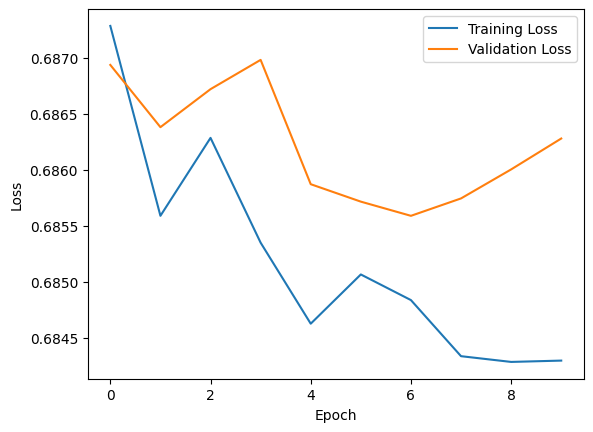

In [27]:
# Train and validate the model
num_epochs = 10

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
  # Train
  model.train()
  train_loss = 0.0
  correct = 0
  total = 0
  for batch_num, (data, labels) in enumerate(train_loader):
    # print(f"batch number {batch_num}")
    optimizer.zero_grad()
    outputs = model(data)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  # Compute training accuracy and loss
  train_acc = 100 * correct / total
  train_loss /= len(train_loader)
  train_accs.append(train_acc)
  train_losses.append(train_loss)

  # Validate
  model.eval()
  val_loss = 0.0
  val_correct = 0
  val_total = 0
  with torch.no_grad():
    for val_data, val_labels in val_loader:
      val_outputs = model(val_data)
      val_loss += criterion(val_outputs, val_labels).item()
      _, val_predicted = torch.max(val_outputs.data, 1)
      val_total += val_labels.size(0)
      val_correct += (val_predicted == val_labels).sum().item()

  # Compute validation accuracy and loss
  val_acc = 100 * val_correct / val_total
  val_loss /= len(val_loader)
  val_accs.append(val_acc)
  val_losses.append(val_loss)

  print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')

# Plot the loss functions
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [28]:
# Test the model
model.eval()
with torch.no_grad():
    y_true = []
    y_pred = []
    for data, labels in test_loader:
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())



In [ ]:
# Evaluation metrics
print('\nClassification Report:')
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

confusion_mtx = confusion_matrix(y_true, y_pred)
sns.heatmap(confusion_mtx, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### F1, Precision, Recall, Sensitivity, Specificity, TP, FP, TN, FN, plot and ROC curve and calculate AUC